/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_37592/1917776008.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_lemmatized'] = df[text_column].apply(lemmatize_text)
/var/folders/c_/d2jd7yn50y93c2sqyws6yswc0000gn/T/ipykernel_37592/1917776008.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text_lemmatized'] = df['clean_text_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= min_word_length]))
/Users/shtosti/opt/anaconda3/envs/gephy/

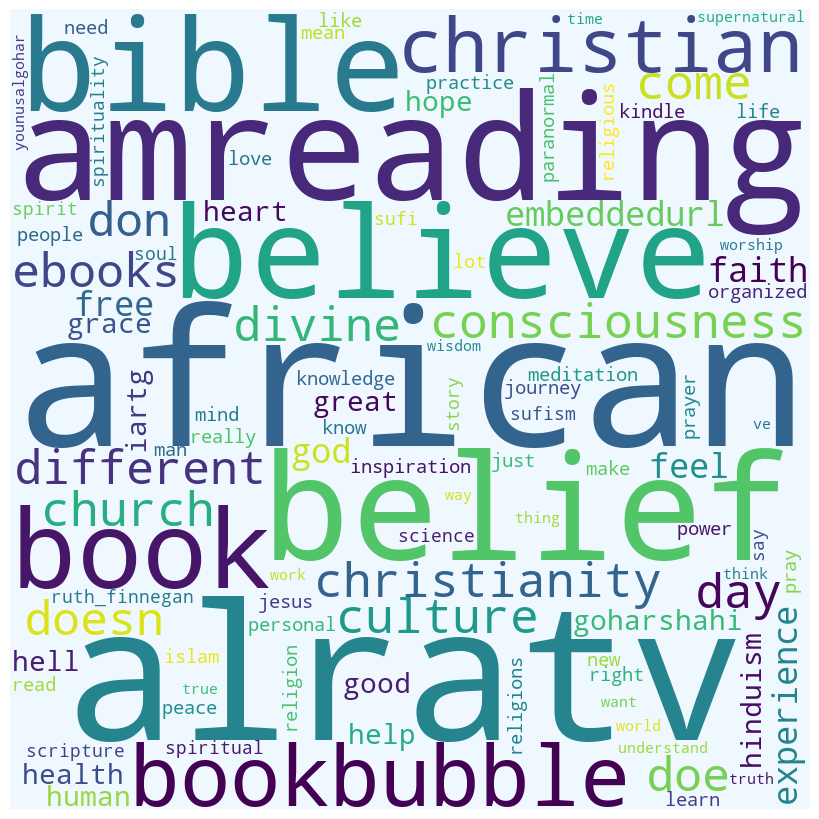

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud


def load_dataset(file_path):
    df = pd.read_csv(file_path)
    return df


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


def preprocess_data(df, text_column='clean_text', min_word_length=3, max_features=100, custom_stopwords=None):
    if custom_stopwords is None:
        custom_stopwords = ENGLISH_STOP_WORDS

    df['clean_text_lemmatized'] = df[text_column].apply(lemmatize_text)
    # filter out short words
    df['clean_text_lemmatized'] = df['clean_text_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= min_word_length]))

    vectorizer = TfidfVectorizer(max_features=max_features, stop_words=list(custom_stopwords))
    X = vectorizer.fit_transform(df['clean_text_lemmatized'])

    return X, vectorizer.get_feature_names_out()


def plot_word_cloud(cluster, feature_names, cluster_number, n_clusters):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='aliceblue',
                          stopwords=None,
                          min_font_size=10).generate_from_frequencies(cluster)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)


    folder_path = f'wordclouds/{n_clusters}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(f'{folder_path}/religion_AND_spirituality_100_{cluster_number}.png')
    plt.show()


def hierarchical_clustering(X_transposed, n_clusters, affinity, linkage):
    model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    clusters = model.fit_predict(X_transposed.toarray())
    return clusters


# update main code for each param
file_path = '/Users/shtosti/Dropbox/study/UZH/FW23/SMA/topic_modelling_DEPO/data/with_clean_keybert_bigrams.csv'
df = load_dataset(file_path)
df_spirituality = df[
    df['clean_text'].str.contains('spirituality', case=False) & ~df['clean_text'].str.contains('religion', case=False)]
df_religion = df[
    df['clean_text'].str.contains('religion', case=False) & ~df['clean_text'].str.contains('spirituality', case=False)]
df_both = df[
    df['clean_text'].str.contains('spirituality', case=False) & df['clean_text'].str.contains('religion', case=False)]

X, feature_names = preprocess_data(df_both)
X_transposed = X.T

# params
n_clusters = 1
affinity = 'euclidean'
linkage_method = 'ward'

clusters = hierarchical_clustering(X_transposed, n_clusters=n_clusters, affinity=affinity, linkage=linkage_method)

# create dict to store words for each cluster
cluster_words = {cluster: [] for cluster in set(clusters)}

# assign feature to cluster
for i, word in enumerate(feature_names):
    cluster_words[clusters[i]].append(word)

# ccreate a word cloud for each cluster
for cluster, words in cluster_words.items():
    cluster_frequencies = {word: 1 for word in words}
    plot_word_cloud(cluster_frequencies, words, cluster, n_clusters)
